## STEP 1: EDA

### THIS PROJECT SHOWS MODEL EVALUATION AND ACTUAL FORECASTING

In [61]:
import pandas as pd #data handling and manipulation
import numpy as np #numerical operations
import matplotlib.pyplot as plt #visualize data
from datetime import datetime #organice time-series into dates
from statsmodels.tsa.stattools import adfuller #ADF test
from statsmodels.tsa.arima.model import ARIMA #powerful model used to forecast future values using past values
from pmdarima import auto_arima #automates (p,d,q)
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose #breaks timeseries into trend, seasonality, and residual components
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

In [62]:
df = pd.read_csv("/Users/andrewabello/Desktop/Superstore_Sales.csv")
df.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [63]:
df.info()
# we are only going to use 2 colums: the Order Date and Sales

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

We need to change the order date to date-time and the sales in monthly sales, as they are daily

In [65]:
# we need to convert the Order date column into Date Time
df['Order Date'] = pd.to_datetime(df['Order Date'],format='%d/%m/%Y')

In [66]:
# Convert daily sales into monthly total sales
# So instead of many rows per month, you get one row per month.
# Adds up all sales within each month
# Models usually want regular time intervals (this time: of sales)
monthly_sales= df.groupby(pd.Grouper(key='Order Date' , freq= 'ME'))['Sales'].sum() #ME = Month End
monthly_sales.head()

Order Date
2015-01-31    14205.707
2015-02-28     4519.892
2015-03-31    55205.797
2015-04-30    27906.855
2015-05-31    23644.303
Freq: ME, Name: Sales, dtype: float64

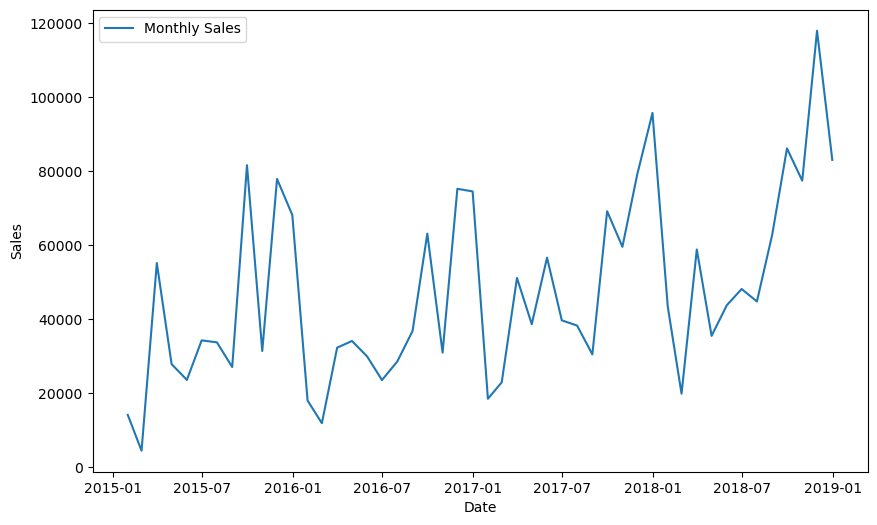

In [67]:
# now lets visualize the monthly sales data
plt.figure(figsize= (10,6))
plt.plot(monthly_sales, label="Monthly Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()
    

## STEP 2: DECOMPOSITION

#### helps identily underliying patterns in time series 

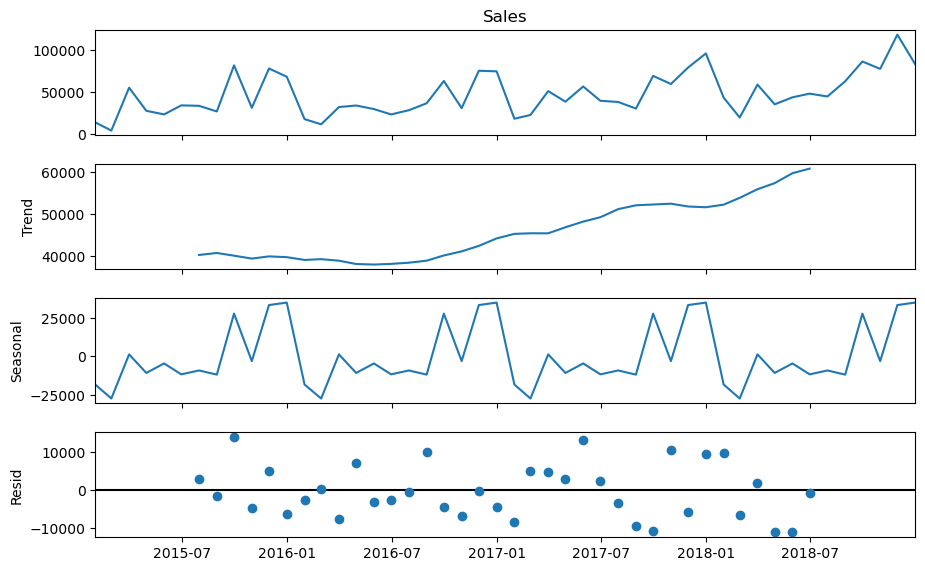

In [69]:
decomposition = seasonal_decompose(monthly_sales, model="Additive")
fig = decomposition.plot()
fig.set_size_inches(10,6)
plt.show()

# as we can see, it has an upward trend
# also, we do have seasonality
# residual represent the random fluctuations or noise that remain after removing the trend and the seasonality components

## STEP 3: CHECK FOR STATIONARITY
#### Mean, Variance and Autocorrelation remain constant over time (statistical properties)
#### We are going to use the ADF Test
    with ADF Test we create a null hypothesis that states that the series has a unit root and is non-stationary. And out alternative hypothesis is that the series is stationary


In [71]:
# we wrote a function that helps us check for stationarity
# If ADF statistic is MORE NEGATIVE than the critical value → stationary

def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print("Augmented Dickey-Fuller Test Results: ")
    print("ADF statistic:", result[0])
    print("P-Value", result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")
    return result[1] < 0.05

is_stationary = check_stationarity(monthly_sales)
print(f"\nTime series is {"stationary" if is_stationary else "non-stationary"}")

# −4.41 = very strong evidence the series is stationary
    

Augmented Dickey-Fuller Test Results: 
ADF statistic: -4.416136761430769
P-Value 0.00027791039276670623
Critical Values:
	1%: -3.5778480370438146
	5%: -2.925338105429433
	10%: -2.6007735310095064

Time series is stationary


## STEP 4: ARIMA MODEL
### As we know that the series is stationary, we can now create our ARIMA model

In [73]:
auto_model = auto_arima(
    monthly_sales,
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    m=12, #Because data is monthly → yearly seasonality
    seasonal=True, #“Also try seasonal ARIMA (SARIMA) terms
    d=None,#No differencing, data already stationary
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

#After making the auto_arima, the system decided that we should use SARIMA(2,1,0)(1,0,0)[12]

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1085.632, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1096.560, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1076.500, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1077.487, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1094.708, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1089.579, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1078.250, Time=0.15 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1078.452, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1080.901, Time=0.07 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1079.864, Time=0.33 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1084.035, Time=0.05 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=1073.635, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=1087.151, Time=0.54 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=1075.267, Time=0.30 sec
 ARIMA(2,1,0)(1,0,1

### Fit the AUTO SARIMA model using statsmodels, based on the parameters that auto_arima found.

In [75]:
model = ARIMA(
    monthly_sales,
    order=auto_model.order,
    seasonal_order=auto_model.seasonal_order 
)    #the best model found by auto_arima lives inside auto_model.order, and auto_model.seasonal_order
results = model.fit()

### This is the actual forecasting step. 
    - we are forecasting the next 12 months of sales using the fitted SARIMA model

In [77]:
forecast_periods = 12  # Predict next 12 months
mean_forecast = results.forecast(steps=forecast_periods)

### Plot the AUTO SARIMA forecast.

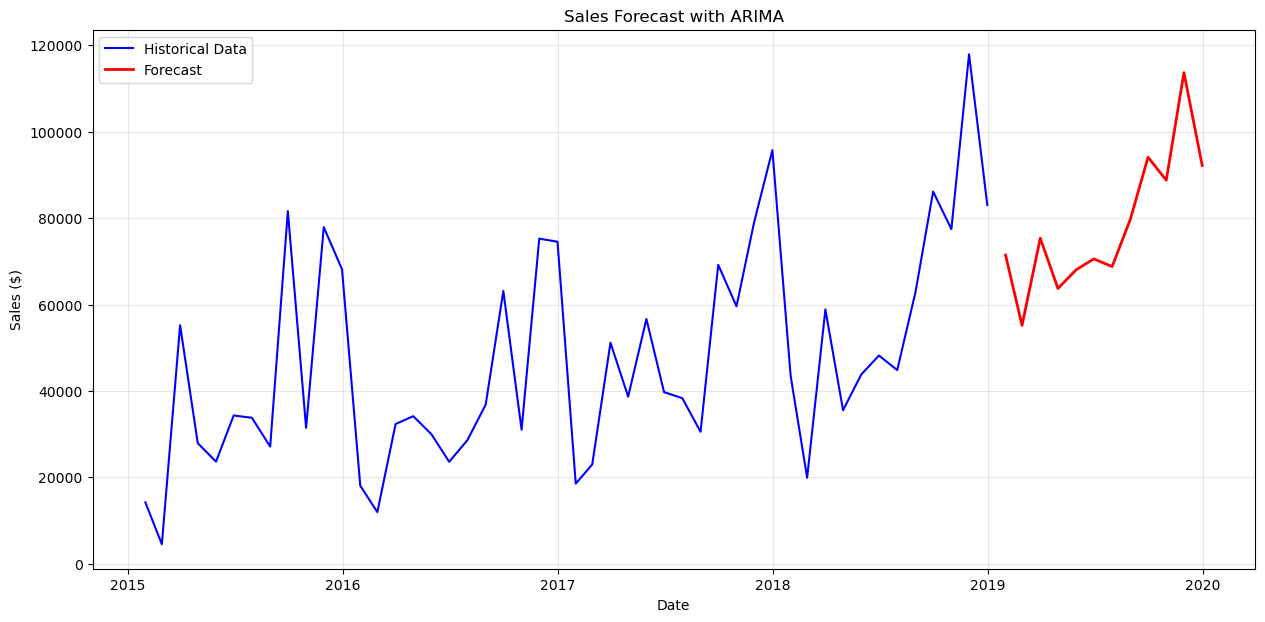

In [79]:
plt.figure(figsize=(15, 7))

# Plot historical data
plt.plot(monthly_sales, label='Historical Data', color='blue')

# Plot forecast
plt.plot(mean_forecast, label='Forecast', color='red', linewidth=2)

# Labels and styling
plt.title('Sales Forecast with ARIMA')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

#The model predicts new dates that do not exist. THIS IS ACTUAL FORECASTING


### Performance Metrics

In [81]:
print("\nModel Performance Metrics:")

mse = mean_squared_error(monthly_sales, results.fittedvalues)
rmse = np.sqrt(mse)
mae = mean_absolute_error(monthly_sales, results.fittedvalues)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# RMSE: On average, the model’s fitted values are about $19K off per month when reproducing historical sales. (That’s called in-sample fit.)
# MAE: On average, the model misses by about $14.4K per month in absolute terms on past data.

# THESE METRICS MEASURE HOW WELL THE MODEL FITS THE HISTORICAL DATA. NOT how good the 2019–2020 forecast is. thats why we are comparing:
# Actual past values → monthly_sales and Model’s fitted values (past predictions) → results.fittedvalues


Model Performance Metrics:
Mean Squared Error (MSE): 372198461.41
Root Mean Squared Error (RMSE): 19292.45
Mean Absolute Error (MAE): 14432.38


## STEP 5: HOLT-WINTERS MODEL

### We are trying different Holt-Winters structures to see how trend and seasonality behave.

### KEY DIFFERENCE: ARIMA models correlation in errors. Holt-Winters models trend and seasonality directly.

In [83]:
# 3 different Holt- Winters Models

models = []
specifications = [
    {
        'name': 'Fixed Parameters (Additive Trend + Additive Seasonality)',
        'model': ExponentialSmoothing(
            monthly_sales,
            seasonal_periods=12,
            trend='add',
            seasonal='add', #Seasonal swings are constant size, ex: +10K every December
            damped_trend=True
        ).fit(
            smoothing_level=0.2, #how fast the level adapts
            smoothing_trend=0.1, #How fast trend adapts
            smoothing_seasonal=0.1, #How fast seasonality adapts
            damping_trend=0.98, #Trend slowly flattens
            optimized=False
        )
    }, #fixed values to make the models comparable, reproducible, and easier to explain
    {
        'name': 'Multiplicative Seasonality',
        'model': ExponentialSmoothing(
            monthly_sales,
            seasonal_periods=12,
            trend='add',
            seasonal='mul', #Seasonal swings grow with the level, ex: +10% every December
            damped_trend=True
        ).fit(
            smoothing_level=0.2,
            smoothing_trend=0.1,
            smoothing_seasonal=0.1,
            damping_trend=0.98,
            optimized=False
        )
    },
    {
        'name': 'Multiplicative Trend',
        'model': ExponentialSmoothing(
            monthly_sales,
            seasonal_periods=12,
            trend='mul',
            seasonal='add',
            damped_trend=True
        ).fit(
            smoothing_level=0.2,
            smoothing_trend=0.1,
            smoothing_seasonal=0.1,
            damping_trend=0.98,
            optimized=False
        )
    }
]

### Evaluate the Holt-Winters models on historical data and deciding which one fits best

In [112]:
# (fittedvalues). Not forecasting yet. This is model evaluation.

results = []
for spec in specifications:
    model = spec['model']
    name = spec['name']

    rmse = np.sqrt(mean_squared_error(monthly_sales, model.fittedvalues)) 
    mae = mean_absolute_error(monthly_sales, model.fittedvalues)
# These do NOT measure forecast accuracy. They measure how well the model fits known data.
    results.append({
        'name': name,
        'rmse': rmse,
        'mae': mae,
        'model': model
    })

### Print the results in a more compelling way

In [114]:
# All these values are computed from: Actual historical sales vs. fitted values
# How well does each Holt-Winters model explain the past?

print("\nModel Comparison:")

for result in results:
    print(f"\n{result['name']}:")
    print(f"RMSE: ${result['rmse']:.2f}")
    print(f"MAE:  ${result['mae']:.2f}")

print(f"\nBest Model: {best_model['name']}")
print(f"Best RMSE: ${best_model['rmse']:.2f}")

# When reproducing the past, this model typically misses by ~$9.8K

#The multiplicative trend Holt-Winters model achieved the lowest RMSE ($9.76K), 
#indicating the best historical fit among the tested specifications and was therefore selected for forecasting.


Model Comparison:

Fixed Parameters (Additive Trend + Additive Seasonality):
RMSE: $9783.60
MAE:  $7831.27

Multiplicative Seasonality:
RMSE: $11758.67
MAE:  $8762.04

Multiplicative Trend:
RMSE: $9762.29
MAE:  $7841.90

Best Model: Multiplicative Trend
Best RMSE: $9762.29


### Pick the best model (based on RMSE).

In [150]:
# Given the best model, what happens in the future?.

best_model = min(results, key=lambda x: x['rmse'])
hw_model = best_model['model']

print(best_model['name'])

# Forecast next 12 periods
hw_forecast = hw_model.forecast(12) 

Multiplicative Trend


### Plot the fitted HW models and the forecasting of the best model (Multiplicative Trend)

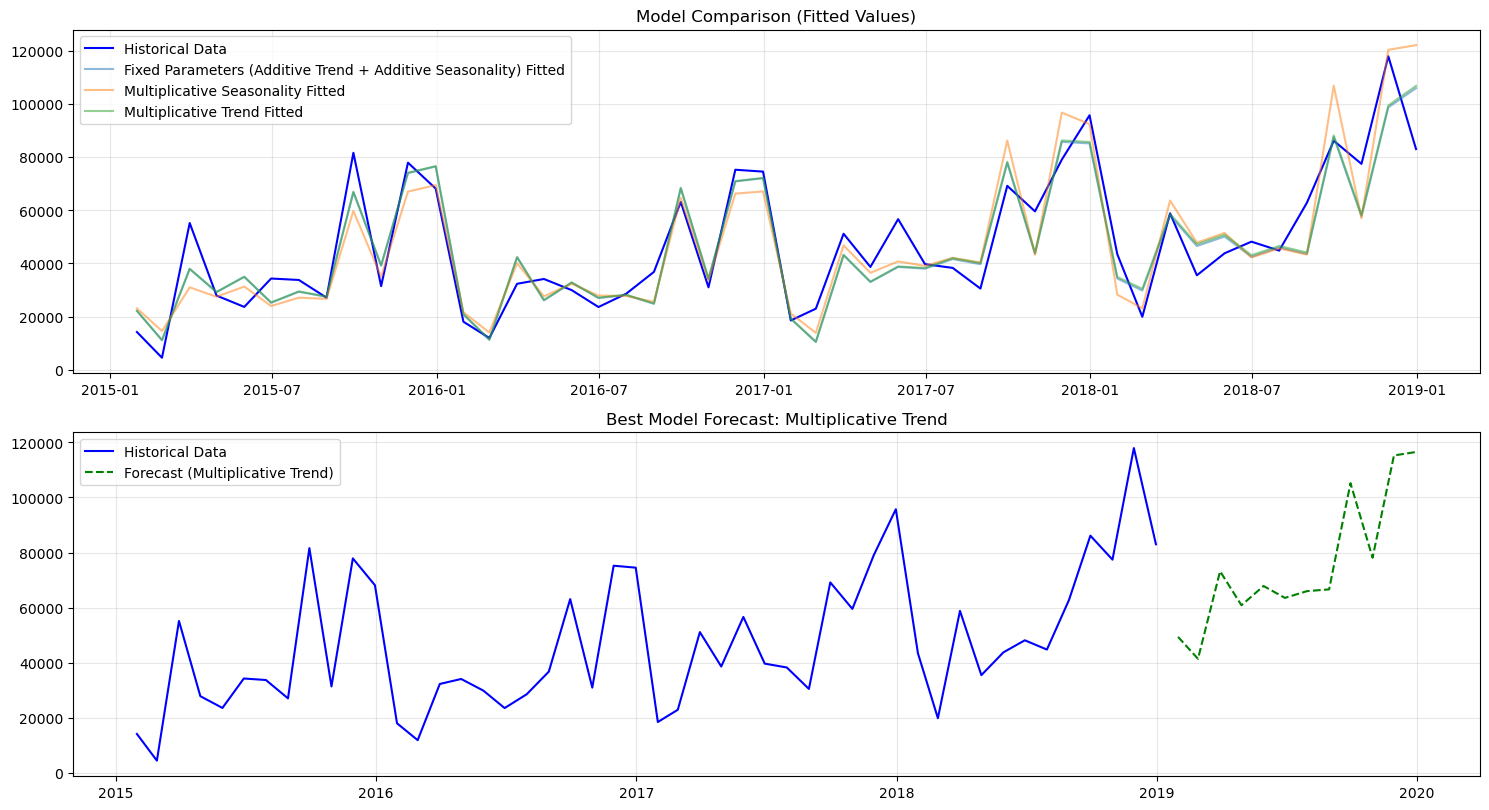

Text(0.5, 1.0, 'Residuals of Multiplicative Trend Model')

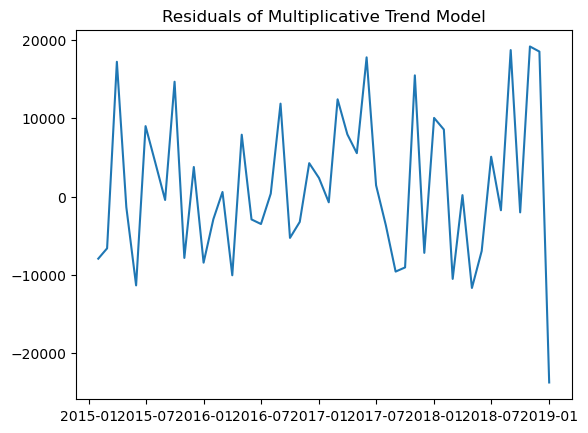

In [168]:

# The first plot is showing all the fitted HW models. 
# this plot is about model evaluation, not forecasting
# visually compare how well each Holt-Winters model fits the historical data.

plt.figure(figsize=(15, 12))

# 1) First subplot: All fitted models
plt.subplot(3, 1, 1)
plt.plot(
    monthly_sales.index,
    monthly_sales,
    label='Historical Data',
    color='blue'
)
for result in results:
    plt.plot(
        result['model'].fittedvalues.index,
        result['model'].fittedvalues,
        label=f"{result['name']} Fitted",
        alpha=0.5
    )
plt.title('Model Comparison (Fitted Values)')
plt.legend()
plt.grid(True, alpha=0.3)

# 2) Second subplot: Best model forecast
## second chart: Given the best model, what do we expect to happen next?

plt.subplot(3, 1, 2)
plt.plot(
    monthly_sales.index,
    monthly_sales,
    label='Historical Data',
    color='blue'
)
plt.plot(
    hw_forecast.index,
    hw_forecast,
    label=f"Forecast ({best_model['name']})",
    color='green',
    linestyle='--'
)
plt.title(f"Best Model Forecast: {best_model['name']}")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3) Third chart Residuals of best model

residuals = monthly_sales - hw_model.fittedvalues
plt.plot(residuals)
plt.title("Residuals of Multiplicative Trend Model")



### HOLT-WINTERS Multiplicative Trend forecast output
    - The model’s predicted sales for the next 12 months

In [88]:
hw_forecast

# The model’s best guess of monthly sales for the next 12 months. using the best Holt-Winters model (Multiplicative Trend).

2019-01-31     49435.711479
2019-02-28     41459.506838
2019-03-31     73220.555712
2019-04-30     60904.078997
2019-05-31     67886.536597
2019-06-30     63574.157506
2019-07-31     66020.931715
2019-08-31     66663.177848
2019-09-30    105201.488326
2019-10-31     78140.769889
2019-11-30    115255.953319
2019-12-31    116513.155267
Freq: ME, dtype: float64

In [160]:
final_results = pd.DataFrame({
    "Actual": monthly_sales,
    "Fitted": hw_model.fittedvalues,
    "Residuals": residuals})
final_results

# As residuals look like white noise (chart above), it mean that the Multiplicative trend model 
# captured very good the trend and the seasonality of the series and what remains is just random noise.

,Actual,Fitted,Residuals
Order Date,,,
2015-01-31,14205.7070,22155.386037,-7949.679037
2015-02-28,4519.8920,11146.811114,-6626.919114
2015-03-31,55205.7970,37975.018760,17230.778240
2015-04-30,27906.8550,29267.192066,-1360.337066
2015-05-31,23644.3030,35011.240872,-11366.937872
2015-06-30,34322.9356,25323.862069,8999.073531
2015-07-31,33781.5430,29471.746667,4309.796333
2015-08-31,27117.5365,27556.862748,-439.326248
2015-09-30,81623.5268,66942.870651,14680.656149
